### Simple Audio Recognition (FFNN)

In this notebook we are going to walk through how we can do audio recoginition practically by example using Feed Forward Neural Networks (FFNN). We will be using the previous notebook as the base notebook.



### Installation of Packages
In the following code cell we are going to install the packages that we are going to use in this notebook.


In this notebook we are going to use the `feed forward neural network` to do audio classification based on spectograms. So we will convert the audio tensors to `spectograms` images and use `FNN` to do the classification of audios.

> Spectograms are image representation of wafeform signals it shows its frequency intensity range over time.  - [towardsai](https://towardsai.net/p/l/a-gentle-introduction-to-audio-classification-with-tensorflow).


In [1]:
!pip install -U --pre tensorflow tensorflow_datasets
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcudnn8 is already the newest version (8.1.0.77-1+cuda11.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


### Imports

In the following code cell we are going to import all the different packages that we are going to use in this notebook. 

In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from IPython import display

keras.__version__, tf.__version__

('2.10.0', '2.10.0')

### Seed
In the following code cell we are going to set the seed for experiment reproducivity.

In [3]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

### Dataset

In this notebook we are going to use the `mini` dataset to save time. The original dataset consists of over `105,000` audio files in the WAV (Waveform) audio file format of people saying `35` different words. This data was collected by Google and released under a CC BY license.

We will download and extract the `mini_speech_commands.zip` file containing the smaller Speech Commands datasets with `tf.keras.utils.get_file`:

In [4]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data'
)


The dataset audios are stored in folders. And there are `8` folders and each folder consist of audios of that command. In the followcing code cell we are going to extract all the commands that we have in this dataset.
  

In [5]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
commands

array(['yes', 'no', 'right', 'go', 'left', 'stop', 'down', 'up'],
      dtype='<U9')

Beacuse our commands are divided into directories we can easily load the data using the [`keras.utils.audio_dataset_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/audio_dataset_from_directory) function.

Our audios are clips that are at most `1` second long and has less thans `16kHz`. The `output_sequence_length=16000` argument pads the short ones to 1 second and trim the long ones to `1s` so that they can be easily batched.

In [6]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed = SEED,
    output_sequence_length=16000,
    subset='both',
    label_mode="categorical" # categorical_crossentropy  loss function
)

label_names = np.array(train_ds.class_names)
label_names

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.


array(['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes'],
      dtype='<U5')

The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`. 

In [7]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 8), dtype=tf.float32, name=None))

This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [8]:
def squeeze(audio, labels):
  return tf.squeeze(audio, axis=-1), labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

The `utils.audio_dataset_from_directory` function only returns up to two splits. It's a good idea to keep a test set separate from your validation set.
Ideally you'd keep it in a separate directory, but in this case you can use `Dataset.shard` to split the validation set into two halves. Note that iterating over `any` shard will load `all` the data, and only keep it's fraction. 

In [9]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [10]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64, 8)


In [11]:
label_names[[1, 1, 3, 0]]

array(['go', 'go', 'no', 'down'], dtype='<U5')

Let's plot waveforms.

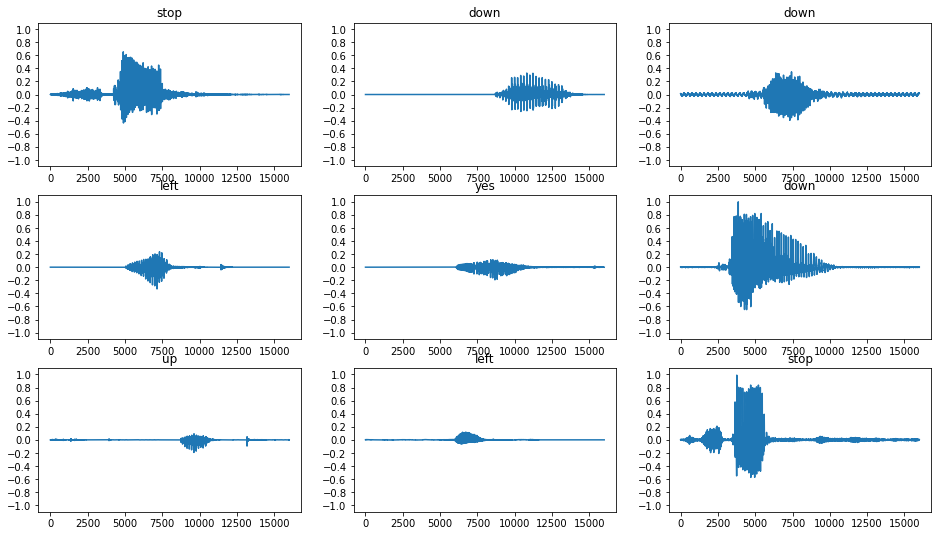

In [12]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  if i>=n:
    break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(example_audio[i].numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label_names[np.argmax(example_labels[i])]
  ax.set_title(label)
  ax.set_ylim([-1.1,1.1])

plt.show()

### Converting waveforms to spectograms


In [13]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [14]:
for i in range(3):
  label = label_names[tf.argmax(example_labels[i])]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  display.display(display.Audio(waveform, rate=16000))
  print()

Label: stop
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)



Label: down
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)



Label: down
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)


Now, define a function for plotting a spectrogram:

In [15]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

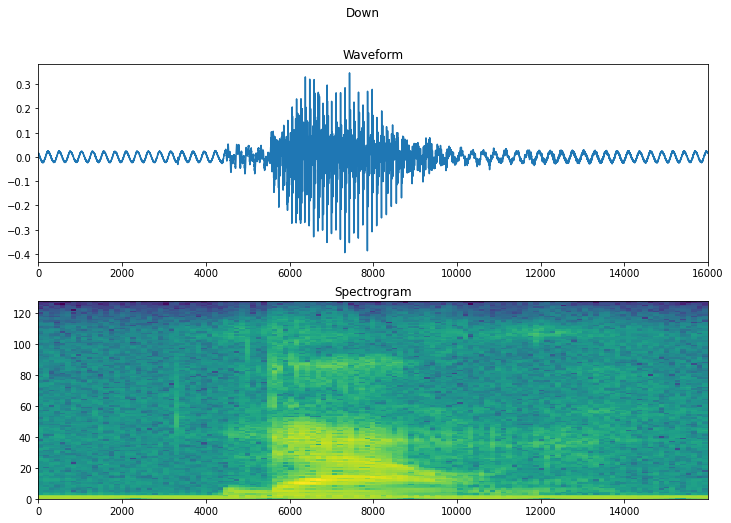

In [16]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now we can create spectogram dataset from the audio dataset for all our `3` different sets.

In [17]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio, label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

Examine the spectrograms for different examples of the dataset:

In [18]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [19]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

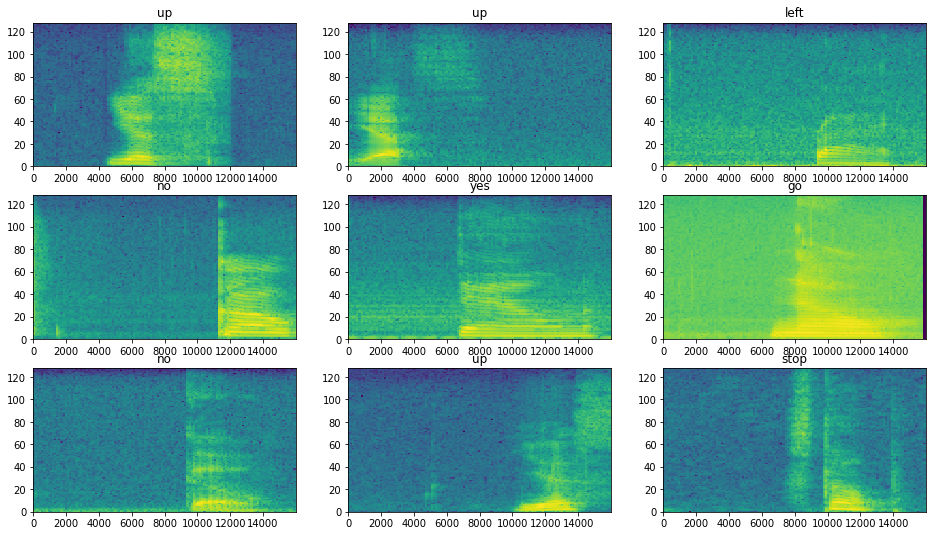

In [20]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(example_spectrograms[i].numpy(), ax)
  ax.set_title(commands[tf.argmax(example_spect_labels[i])])

plt.show()

### Building and Training Our Model

Our model will be trained based on the spectogram dataset. We are going to  apply `cache` and `prefetch` operations on our dataset to reduce latency while training the model.

Our model in this notebook will be using `Feed Forward Neural Network (FFNN)` since we transformed our audios into spectograms images, we need a way of flattening these image tensors so that they can be passed directly to the `Dense` layers of our `Sequential` model.

Our `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Flatten`: flattens the multi-dimentional tensor to a 1d tensor so that it can be directly passed to the `Dense` layer.




In [21]:
input_shape = example_spectrograms.shape[1:]
num_labels = len(commands)
input_shape, num_labels

(TensorShape([124, 129, 1]), 8)

In [22]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=input_shape),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(num_labels)
], name="asr")

model.summary()

Model: "asr"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 15996)             0         
                                                                 
 dense (Dense)               (None, 128)               2047616   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
Total params: 2,056,392
Trainable params: 2,056,392
Non-trainable params: 0
_________________________________________________________________


### Combiling the model.

Note that we are going to use the `Adam` optimizer with default parameters and `CategoricalCrossentropy` loss function an we are going to set `from_logits=False` since the last layer of our model has a `sigmoid` activation function. The reason we are using `CategoricalCrossentropy` loss function is because our labels are integer values and they are `one-hot-encoded`.

In [23]:
model.compile(
    optimizer= keras.optimizers.Adam(),
    loss= keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Training the model for `10` epochs.

In [24]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks= keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 [==============================] - 16s 142ms/step - loss: 1.6457 - accuracy: 0.4769 - val_loss: 1.3802 - val_accuracy: 0.5846
Epoch 2/10
100/100 [==============================] - 18s 174ms/step - loss: 1.0212 - accuracy: 0.6998 - val_loss: 1.1612 - val_accuracy: 0.6602
Epoch 3/10
100/100 [==============================] - 11s 109ms/step - loss: 0.7701 - accuracy: 0.7719 - val_loss: 1.0402 - val_accuracy: 0.6953
Epoch 4/10
100/100 [==============================] - 10s 93ms/step - loss: 0.6203 - accuracy: 0.8178 - val_loss: 1.1746 - val_accuracy: 0.7083
Epoch 5/10
100/100 [==============================] - 9s 91ms/step - loss: 0.4989 - accuracy: 0.8534 - val_loss: 1.1014 - val_accuracy: 0.7148
Epoch 5: early stopping


Let's plot the training and validation loss curves to check how your model has improved during training:

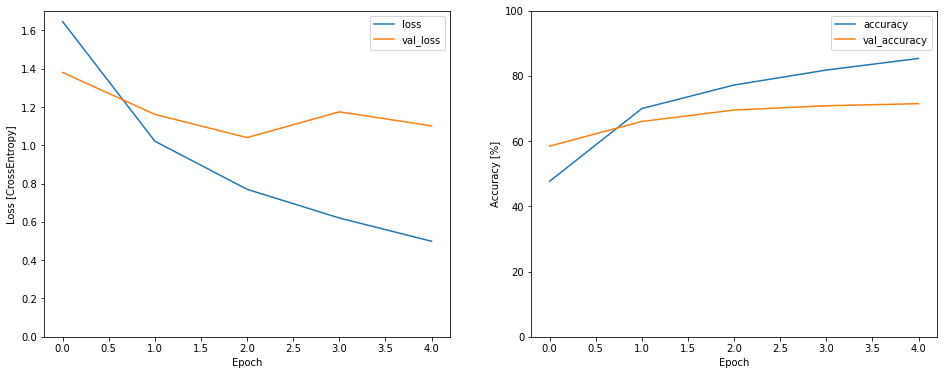

In [25]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.show()

### Evaluating the model

In the following code cell we are going to evaluate our model based on the `test` dataset.

In [26]:
model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 [==============================] - 1s 102ms/step - loss: 1.1332 - accuracy: 0.7163


{'loss': 1.1331849098205566, 'accuracy': 0.7163461446762085}

### Confusion Matrix

We are going to use the confusion matrix to check how well did the model classify our test dataset.

In [27]:
y_pred = model.predict(test_spectrogram_ds)

13/13 [==============================] - 1s 103ms/step


In [28]:
y_pred = tf.argmax(y_pred, axis=1)

In [29]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)
y_true = tf.argmax(y_true, axis=1)

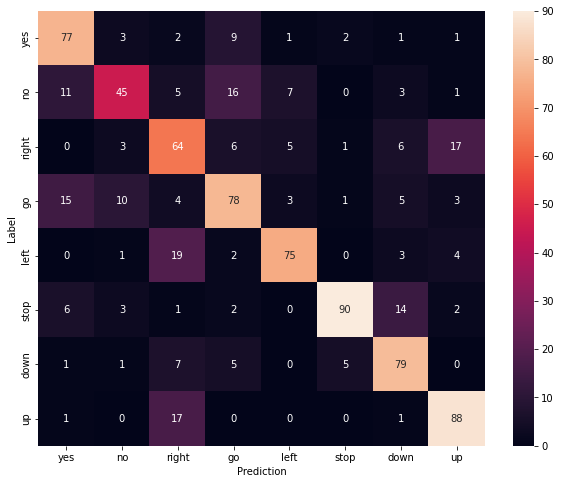

In [30]:
cm = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm,
            xticklabels=commands,
            yticklabels=commands,
            annot=True,
            fmt='g'
          )
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### Model inference

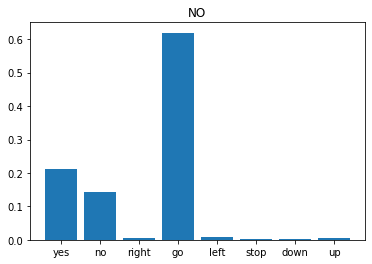

Predicted: 	GO
Real Label: 	NO


In [31]:
def predict_command(filename:str):
  label = filename.split('/')[2].upper()
  x = tf.io.read_file(filename)
  x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
  x = tf.squeeze(x, axis=-1) 
  waveform = x
  x = x[tf.newaxis, :]
  x = get_spectrogram(x)
  prediction = model(x, training=False)
  prediction = tf.squeeze(prediction)

  plt.bar(commands, tf.nn.softmax(prediction))
  plt.title(label)
  plt.show()
  print()
  display.display(display.Audio(waveform, rate=16000))
  print(f"Predicted: \t{commands[tf.argmax(prediction)].upper()}")
  print(f"Real Label: \t{label}")

predict_command(f"{data_dir}/no/01bb6a2a_nohash_0.wav")

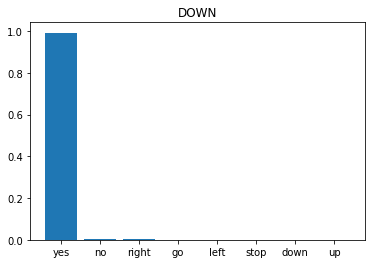

Predicted: 	YES
Real Label: 	DOWN


In [32]:
# Down
predict_command(f"{data_dir}/down/004ae714_nohash_0.wav")

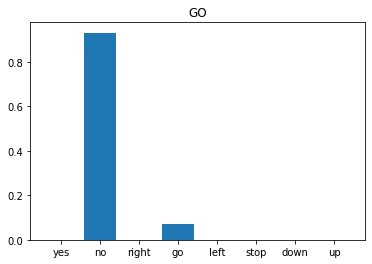

Predicted: 	NO
Real Label: 	GO


In [33]:
# Go
predict_command(f"{data_dir}/go/0132a06d_nohash_2.wav")

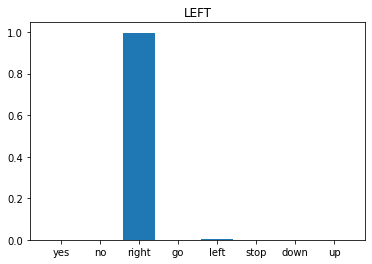

Predicted: 	RIGHT
Real Label: 	LEFT


In [34]:
# Left
predict_command(f"{data_dir}/left/00b01445_nohash_0.wav")

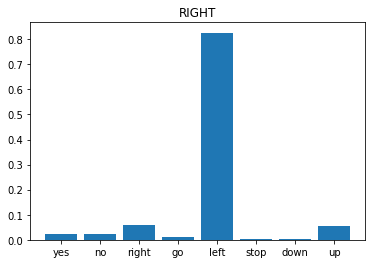

Predicted: 	LEFT
Real Label: 	RIGHT


In [35]:
# Right
predict_command(f"{data_dir}/right/012c8314_nohash_1.wav")

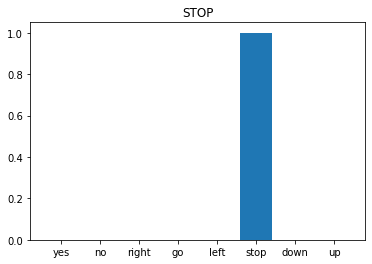

Predicted: 	STOP
Real Label: 	STOP


In [36]:
# Stop
predict_command(f"{data_dir}/stop/012c8314_nohash_0.wav")

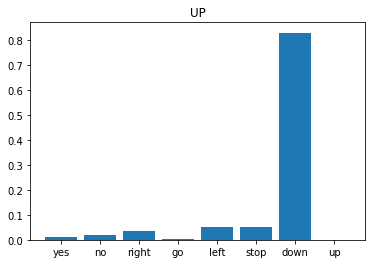

Predicted: 	DOWN
Real Label: 	UP


In [37]:
# Up
predict_command(f"{data_dir}/up/0135f3f2_nohash_1.wav")

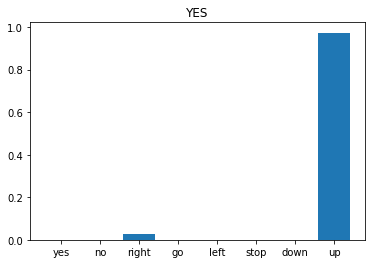

Predicted: 	UP
Real Label: 	YES


In [38]:
# Yes
predict_command(f"{data_dir}/yes/004ae714_nohash_0.wav")

### Export the model with preprocessing

The model's not very easy to use if you have to apply those preprocessing steps before passing data to the model for inference. So build an end-to-end version:

In [39]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]
    
    x = get_spectrogram(x)  
    result = self.model(x, training=False)
    
    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {
        'predictions':result,
        'class_ids': class_ids,
        'class_names': class_names
        }
      

Test the export model

In [40]:
export = ExportModel(model)
export(tf.constant(str(data_dir/'no/01bb6a2a_nohash_0.wav')))

{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[ 2.8858626,  2.5015626, -0.7995214,  3.9585073, -0.2609363,
         -1.6384536, -1.7010462, -0.7599745]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>}

In [41]:
export(tf.constant(f"{data_dir}/yes/004ae714_nohash_0.wav"))

{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[-4.0671005, -0.6641945,  8.154603 , -1.9055034,  2.571658 ,
         -1.8724967, -3.6701927, 11.770597 ]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([7])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'yes'], dtype=object)>}

In [42]:
export(tf.constant(f"{data_dir}/right/012c8314_nohash_1.wav"))

{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[-0.04913041,  0.07181466,  0.9324928 , -0.84135157,  3.6035008 ,
         -1.9463785 , -2.0989423 ,  0.90816677]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([4])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'right'], dtype=object)>}

In [43]:
export(tf.constant(f"{data_dir}/up/0135f3f2_nohash_1.wav"))

{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[ 0.12866777,  0.7647437 ,  1.4790535 , -1.0421885 ,  1.8048505 ,
          1.8358262 ,  4.599064  , -2.5388293 ]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([6])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'up'], dtype=object)>}

In [44]:
export(tf.constant(f"{data_dir}/go/0132a06d_nohash_2.wav"))

{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[  0.7076091 ,   9.160355  ,  -0.862316  ,   6.5579114 ,
           0.09045564,  -6.8154345 , -10.480744  ,  -3.3073797 ]],
       dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'go'], dtype=object)>}

Save and reload the model, the reloaded model gives identical output:

In [45]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[ 6.5236473 ,  0.98493415, -2.1571033 ,  3.3404477 , -0.5491392 ,
         -0.49119112, -2.9222293 ,  0.13626078]], dtype=float32)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'down'], dtype=object)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>}

### Ref

1. [tensorflow tutorials](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb#scrollTo=2-rayb7-3Y0I)

2. [towardsAI](https://towardsai.net/p/l/a-gentle-introduction-to-audio-classification-with-tensorflow)